# QBUS6830 Tutorial Lab 4: Stress testing CAPM and PCA

## Before we Begin

## Other Material

Just becareful, they use Python 2 but we use Python 3. So a lot of their code won't work if you just copy and paste.

https://gist.github.com/ih2502mk/50d8f7feb614c8676383431b056f4291

- VaR and CVaR: https://github.com/quantopian/research_public/tree/master/notebooks/lectures/VaR_and_CVaR
- PCA Analysis: https://github.com/quantopian/research_public/blob/master/notebooks/lectures/PCA/notebook.ipynb


## Data
Get the Kenneth French data on factors and 5 industry portfolios (value-weighted) on a MONTHLY frequency from the files `F-F_Research Data Factors_m.txt` and `5_Industry Portfolios_m.txt`. Note that these data files contain both Monthly and Annual data so you will have to scroll down to find and select the appropriate data set in each of the text files.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.stats import norm
from datetime import datetime
from statsmodels.stats.stattools import jarque_bera

In [50]:
# Import data
dp = lambda x: datetime.strptime(x, '%Y%m')
skip_ff = np.concatenate([np.arange(3),  np.arange(1030, 1121)])
skip_ip = np.concatenate([np.arange(11),  np.arange(1038, 4489)])
data_ff = pd.read_csv('F-F_Research_Data_Factors_m.txt', skiprows=skip_ff, sep='\s+', date_parser=dp)
data_ip = pd.read_csv('5_Industry_Portfolios_m.txt', skiprows=skip_ip, sep='\s+', date_parser=dp)

### Question 1 Stress testing CAPM

#### (a) Fit the multi-factor CAPM model to each of the five industry group portfolio excess return series.


In [51]:
data_ip.head()

,Cnsmr,Manuf,HiTec,Hlth,Other
1926-07-01,4.10,2.73,1.83,1.64,2.12
1926-08-01,2.58,2.26,2.41,4.51,4.36
1926-09-01,2.06,-0.39,1.06,0.61,0.29
1926-10-01,-4.65,-2.42,-2.26,-0.73,-2.85
1926-11-01,3.19,2.54,3.07,5.53,2.13


In [52]:
# Excess returns
exr_ip = data_ip.sub(data_ff['RF'], axis=0)
exr = exr_ip.merge(data_ff.iloc[:,0:3], left_index=True, right_index=True)
exr

,Cnsmr,Manuf,HiTec,Hlth,Other,Mkt-RF,SMB,HML
1926-07-01,3.88,2.51,1.61,1.42,1.90,2.62,-2.16,-2.92
1926-08-01,2.33,2.01,2.16,4.26,4.11,2.56,-1.49,4.88
1926-09-01,1.83,-0.62,0.83,0.38,0.06,0.36,-1.38,-0.01
1926-10-01,-4.97,-2.74,-2.58,-1.05,-3.17,-3.43,0.04,0.71
1926-11-01,2.88,2.23,2.76,5.22,1.82,2.44,-0.24,-0.31
...,...,...,...,...,...,...,...,...
2011-08-01,-2.87,-6.76,-6.40,-3.31,-8.16,-5.85,-3.24,-1.49
2011-09-01,-5.08,-9.99,-4.97,-4.07,-11.07,-8.43,-3.58,-0.99
2011-10-01,9.37,13.66,10.79,5.54,13.61,11.53,3.53,-0.90
2011-11-01,0.42,1.43,-1.44,1.47,-2.00,-0.61,-0.22,-0.02


In [53]:
X = exr.iloc[:,5:8]
X = sm.add_constant(X)
res = np.empty(5, dtype=object)
a = np.empty(5)
b1 = np.empty(5)
b2 = np.empty(5)
b3 = np.empty(5)
ci_a = np.empty(5, dtype=object)
ci_b1 = np.empty(5, dtype=object)
ci_b2 = np.empty(5, dtype=object)
ci_b3 = np.empty(5, dtype=object)

for i in range(5):
    res[i] = sm.OLS(exr.iloc[:, i], X).fit()
    a[i] = res[i].params[0].round(3)
    b1[i] = res[i].params[1].round(3)
    b2[i] = res[i].params[2].round(3)
    b3[i] = res[i].params[3].round(3)
    ci = res[i].conf_int(alpha=0.05)
    ci_a[i] = '({:.3f}, {:.3f})'.format(ci.iloc[0, 0], ci.iloc[0, 1])
    ci_b1[i] = '({:.3f}, {:.3f})'.format(ci.iloc[1, 0], ci.iloc[1, 1])
    ci_b2[i] = '({:.3f}, {:.3f})'.format(ci.iloc[2, 0], ci.iloc[2, 1])
    ci_b3[i] = '({:.3f}, {:.3f})'.format(ci.iloc[3, 0], ci.iloc[3, 1])
tbl_coef = pd.DataFrame(data={'alpha': a, 'CI_alpha': ci_a, 'b1 (Mkt)': b1, 'CI_beta 1': ci_b1,
                             'b2 (SMB)': b2, 'CI_beta 2': ci_b2, 'b3 (HML)': b3, 'CI_beta 3': ci_b3}) 
tbl_coef.index = exr.columns[:5]
tbl_coef

,alpha,CI_alpha,b1 (Mkt),CI_beta 1,b2 (SMB),CI_beta 2,b3 (HML),CI_beta 3
Cnsmr,0.124,"(0.006, 0.243)",0.921,"(0.898, 0.944)",0.012,"(-0.025, 0.050)",-0.006,"(-0.039, 0.028)"
Manuf,0.038,"(-0.049, 0.126)",0.981,"(0.964, 0.999)",-0.096,"(-0.124, -0.068)",0.159,"(0.134, 0.184)"
HiTec,0.132,"(0.001, 0.263)",0.987,"(0.961, 1.013)",0.037,"(-0.005, 0.078)",-0.326,"(-0.363, -0.289)"
Hlth,0.318,"(0.111, 0.525)",0.892,"(0.851, 0.932)",-0.095,"(-0.161, -0.030)",-0.189,"(-0.248, -0.130)"
Other,-0.223,"(-0.343, -0.103)",1.055,"(1.031, 1.078)",0.066,"(0.028, 0.104)",0.371,"(0.336, 0.405)"


# Answer guide #
As discussed in Lab 3 solutions.

#### (b) Estimate the average (and standard deviation of) industry return, for each industry, for each combination of the following cases:
1. The excess market return is -5%, -10%
2. HML is 0%, -2%
3. SMB is 0%, -2%

In [30]:
# WHAT IS THIS??????
f_new = np.matrix([[-5, 0, 0],
                   [-5, 0, -2],
                   [-5, -2, 0],
                   [-5, -2, -2],
                   [-10, 0, 0],
                   [-10, 0, -2],
                   [-10, -2, 0],
                   [-10, -2, -2]])

In [55]:
x_new = sm.add_constant(f_new)
x_new

matrix([[  1.,  -5.,   0.,   0.],
        [  1.,  -5.,   0.,  -2.],
        [  1.,  -5.,  -2.,   0.],
        [  1.,  -5.,  -2.,  -2.],
        [  1., -10.,   0.,   0.],
        [  1., -10.,   0.,  -2.],
        [  1., -10.,  -2.,   0.],
        [  1., -10.,  -2.,  -2.]])

In [32]:
# ???????????????
y_hat = np.empty((8, 5))
y_std = np.empty(5)
for i in range(5):
    y_hat[:, i] = res[i].predict(x_new)
    y_std[i] = np.sqrt(res[i].mse_resid)
y_hat

array([[ -4.48195475,  -4.86905608,  -4.80204246,  -4.14047931,
         -5.49770602],
       [ -4.47038205,  -5.18728957,  -4.14997154,  -3.7627979 ,
         -6.23881889],
       [ -4.5066696 ,  -4.67685377,  -4.87547143,  -3.94971374,
         -5.63039209],
       [ -4.4950969 ,  -4.99508725,  -4.22340051,  -3.57203234,
         -6.37150496],
       [ -9.08827434,  -9.77645288,  -9.73618545,  -8.59901606,
        -10.77235663],
       [ -9.07670164, -10.09468636,  -9.08411452,  -8.22133465,
        -11.5134695 ],
       [ -9.11298919,  -9.58425057,  -9.80961442,  -8.40825049,
        -10.90504269],
       [ -9.10141649,  -9.90248405,  -9.15754349,  -8.03056909,
        -11.64615556]])

In [57]:
exr.head()

,Cnsmr,Manuf,HiTec,Hlth,Other,Mkt-RF,SMB,HML
1926-07-01,3.88,2.51,1.61,1.42,1.90,2.62,-2.16,-2.92
1926-08-01,2.33,2.01,2.16,4.26,4.11,2.56,-1.49,4.88
1926-09-01,1.83,-0.62,0.83,0.38,0.06,0.36,-1.38,-0.01
1926-10-01,-4.97,-2.74,-2.58,-1.05,-3.17,-3.43,0.04,0.71
1926-11-01,2.88,2.23,2.76,5.22,1.82,2.44,-0.24,-0.31


In [60]:
i = 1
# res[i] = sm.OLS(exr.iloc[:, i], X).fit()
res[i].predict(x_new)

array([ -4.86905608,  -5.18728957,  -4.67685377,  -4.99508725,
        -9.77645288, -10.09468636,  -9.58425057,  -9.90248405])

In [61]:
x_new

matrix([[  1.,  -5.,   0.,   0.],
        [  1.,  -5.,   0.,  -2.],
        [  1.,  -5.,  -2.,   0.],
        [  1.,  -5.,  -2.,  -2.],
        [  1., -10.,   0.,   0.],
        [  1., -10.,   0.,  -2.],
        [  1., -10.,  -2.,   0.],
        [  1., -10.,  -2.,  -2.]])

This will be explored later on in the course, but in financial timeseries it is typical to think of the timeseries as being composed of a mean process (or trend) and a volatility process. Meaning

$$Y = \textrm{Mean Process} + \textrm{Volatility Process}$$

As such, we simply define volatility as 
$$\textrm{Volatility Process} = Y - \textrm{Mean Process}$$

This mean process is simply the prediction from the regression. That is
$$\textrm{Mean Process} = \beta_0 + \beta_1X_1+\cdots + \beta_pX_p$$

As such, how volatilite an asset is is simply
$$\textrm{Volatility Process} = Y - (\beta_0 + \beta_1X_1+\cdots + \beta_pX_p)$$

Which is simply the residuals of the regression! In other words, we treat the residuals of the regression as the volatility of the asset.

Note, the reason why we think of the timeseries as a mean process + volatility process is that the mean process (i.e. the regression model) is basically our best attempt at predicting tomorrows prices. But if tomorrows price is different from our prediction, we assume this is because of how volatile the stock is.

In [33]:
exr.head()

,Cnsmr,Manuf,HiTec,Hlth,Other,Mkt-RF,SMB,HML
1926-07-01,3.88,2.51,1.61,1.42,1.90,2.62,-2.16,-2.92
1926-08-01,2.33,2.01,2.16,4.26,4.11,2.56,-1.49,4.88
1926-09-01,1.83,-0.62,0.83,0.38,0.06,0.36,-1.38,-0.01
1926-10-01,-4.97,-2.74,-2.58,-1.05,-3.17,-3.43,0.04,0.71
1926-11-01,2.88,2.23,2.76,5.22,1.82,2.44,-0.24,-0.31


In [63]:
i = 0

# res[i] = sm.OLS(exr.iloc[:, i], X).fit()
model = res[i]

In [64]:
model.resid

1926-07-01    1.351720
1926-08-01   -0.106151
1926-09-01    1.390976
1926-10-01   -1.930816
1926-11-01    0.508923
                ...   
2011-08-01    2.426445
2011-09-01    2.600401
2011-10-01   -1.425367
2011-11-01    0.860209
2011-12-01    0.558441
Length: 1026, dtype: float64

In [65]:
# Y - Y_hat
exr.iloc[:, i] - model.predict(X)

1926-07-01    1.351720
1926-08-01   -0.106151
1926-09-01    1.390976
1926-10-01   -1.930816
1926-11-01    0.508923
                ...   
2011-08-01    2.426445
2011-09-01    2.600401
2011-10-01   -1.425367
2011-11-01    0.860209
2011-12-01    0.558441
Length: 1026, dtype: float64

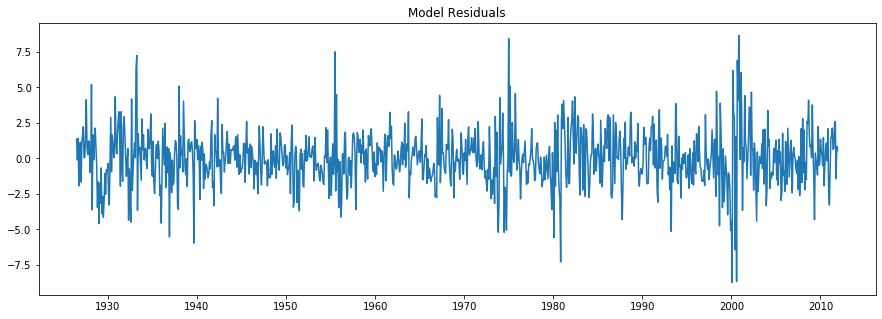

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(model.resid)
plt.title("Model Residuals");

In [68]:
# Root mean square error of residuals
np.sqrt(np.mean(model.resid ** 2))

1.9063824533689555

In [39]:
tbl_yhat = pd.DataFrame(np.hstack((f_new, y_hat.round(4))))
tbl_yhat.columns = np.concatenate((exr.columns[5:], exr.columns[:5]))
tbl_yhat

,Mkt-RF,SMB,HML,Cnsmr,Manuf,HiTec,Hlth,Other
0,-5.0,0.0,0.0,-4.4820,-4.8691,-4.8020,-4.1405,-5.4977
1,-5.0,0.0,-2.0,-4.4704,-5.1873,-4.1500,-3.7628,-6.2388
2,-5.0,-2.0,0.0,-4.5067,-4.6769,-4.8755,-3.9497,-5.6304
3,-5.0,-2.0,-2.0,-4.4951,-4.9951,-4.2234,-3.5720,-6.3715
4,-10.0,0.0,0.0,-9.0883,-9.7765,-9.7362,-8.5990,-10.7724
5,-10.0,0.0,-2.0,-9.0767,-10.0947,-9.0841,-8.2213,-11.5135
6,-10.0,-2.0,0.0,-9.1130,-9.5843,-9.8096,-8.4083,-10.9050
7,-10.0,-2.0,-2.0,-9.1014,-9.9025,-9.1575,-8.0306,-11.6462


In [73]:
i = 2
res[i].predict(x_new)

array([-4.80204246, -4.14997154, -4.87547143, -4.22340051, -9.73618545,
       -9.08411452, -9.80961442, -9.15754349])

In [74]:
x_new

matrix([[  1.,  -5.,   0.,   0.],
        [  1.,  -5.,   0.,  -2.],
        [  1.,  -5.,  -2.,   0.],
        [  1.,  -5.,  -2.,  -2.],
        [  1., -10.,   0.,   0.],
        [  1., -10.,   0.,  -2.],
        [  1., -10.,  -2.,   0.],
        [  1., -10.,  -2.,  -2.]])

In [40]:
tbl_ystd = pd.DataFrame({'SD': y_std.round(4)}).T
tbl_ystd.columns = exr.columns[:5]
tbl_ystd

,Cnsmr,Manuf,HiTec,Hlth,Other
SD,1.9101,1.4145,2.1134,3.3396,1.9336


In [79]:
i = 4

np.sqrt(res[i].mse_resid)

1.9336256831121772

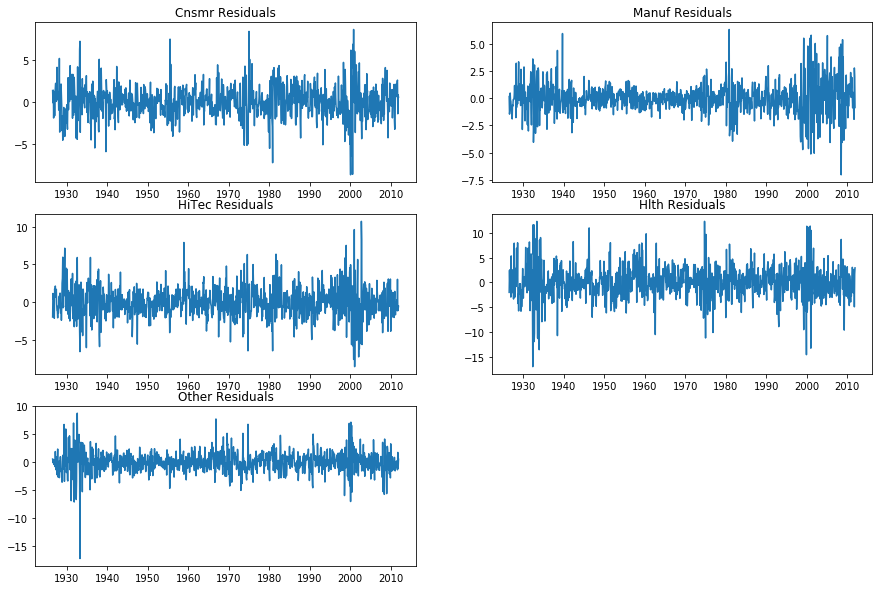

In [41]:
plt.figure(figsize=(15, 10))
for i, portfolio in enumerate(['Cnsmr', 'Manuf', 'HiTec', 'Hlth', 'Other']):
    plt.subplot(3, 2, i + 1)
    plt.plot(res[i].resid)
    plt.title(f"{portfolio} Residuals")

# Answer guide #
We now start to understand more about the risk profile of each sector. 

Other has the highest market beta and a (significantly) high market risk: it has the most extreme expected values for return losses under each scenario. Whilst Health has the lowest market beta and a (significantly) low market risk: it has the least extreme expected values for return losses under each scenario.

Apart from Other, in most scenarios the other 4 sectors have less extreme losses than the associated market return loss, influenced by their market betas being less than 1.

However, in terms of variation, Health has the highest return variance and Manufacturing the smallest. Below we will see how the differing variances affect the (tail) risk profiles.

#### (c) For each combination in (b), estimate a Value at Risk and expected shortfall at the 1% level, for each asset, using the Gaussian distribution and a sample percentile approach. Discuss.

In [42]:
# Gaussian percentile 0.01
print(norm.ppf(0.01))

# Gaussian percentile for ES(0.01)
print(-stats.norm.pdf( stats.norm.ppf( 0.01 ) ) / 0.01)

-2.3263478740408408
-2.665214220345808


In [43]:
# Parametric VaR
tbl_var_par = tbl_yhat.copy()
tbl_var_par.iloc[:, 3:] = tbl_yhat.iloc[:, 3:] + np.tile(tbl_ystd * norm.ppf(0.01), (8, 1))
tbl_var_par

,Mkt-RF,SMB,HML,Cnsmr,Manuf,HiTec,Hlth,Other
0,-5.0,0.0,0.0,-8.925557,-8.159719,-9.718504,-11.909571,-9.995926
1,-5.0,0.0,-2.0,-8.913957,-8.477919,-9.066504,-11.531871,-10.737026
2,-5.0,-2.0,0.0,-8.950257,-7.967519,-9.792004,-11.718771,-10.128626
3,-5.0,-2.0,-2.0,-8.938657,-8.285719,-9.139904,-11.341071,-10.869726
4,-10.0,0.0,0.0,-13.531857,-13.067119,-14.652704,-16.368071,-15.270626
5,-10.0,0.0,-2.0,-13.520257,-13.385319,-14.000604,-15.990371,-16.011726
6,-10.0,-2.0,0.0,-13.556557,-12.874919,-14.726104,-16.177371,-15.403226
7,-10.0,-2.0,-2.0,-13.544957,-13.193119,-14.074004,-15.799671,-16.144426


In [89]:
tbl_yhat.iloc[:, 3:]

,Cnsmr,Manuf,HiTec,Hlth,Other
0,-4.4820,-4.8691,-4.8020,-4.1405,-5.4977
1,-4.4704,-5.1873,-4.1500,-3.7628,-6.2388
2,-4.5067,-4.6769,-4.8755,-3.9497,-5.6304
3,-4.4951,-4.9951,-4.2234,-3.5720,-6.3715
4,-9.0883,-9.7765,-9.7362,-8.5990,-10.7724
5,-9.0767,-10.0947,-9.0841,-8.2213,-11.5135
6,-9.1130,-9.5843,-9.8096,-8.4083,-10.9050
7,-9.1014,-9.9025,-9.1575,-8.0306,-11.6462


In [83]:
tbl_ystd * norm.ppf(0.01)

,Cnsmr,Manuf,HiTec,Hlth,Other
SD,-4.443557,-3.290619,-4.916504,-7.769071,-4.498226


In [44]:
# Becareful with what the Quantopian people do
# They subtract the 99-quantile, while we add the 1-quantile

tbl_var_par = tbl_yhat.copy()
tbl_var_par.iloc[:, 3:] = tbl_yhat.iloc[:, 3:] - np.tile(tbl_ystd * norm.ppf(0.99), (8, 1))
tbl_var_par

,Mkt-RF,SMB,HML,Cnsmr,Manuf,HiTec,Hlth,Other
0,-5.0,0.0,0.0,-8.925557,-8.159719,-9.718504,-11.909571,-9.995926
1,-5.0,0.0,-2.0,-8.913957,-8.477919,-9.066504,-11.531871,-10.737026
2,-5.0,-2.0,0.0,-8.950257,-7.967519,-9.792004,-11.718771,-10.128626
3,-5.0,-2.0,-2.0,-8.938657,-8.285719,-9.139904,-11.341071,-10.869726
4,-10.0,0.0,0.0,-13.531857,-13.067119,-14.652704,-16.368071,-15.270626
5,-10.0,0.0,-2.0,-13.520257,-13.385319,-14.000604,-15.990371,-16.011726
6,-10.0,-2.0,0.0,-13.556557,-12.874919,-14.726104,-16.177371,-15.403226
7,-10.0,-2.0,-2.0,-13.544957,-13.193119,-14.074004,-15.799671,-16.144426


In [45]:
-stats.norm.pdf( stats.norm.ppf( 0.01 ) ) / 0.01

-2.665214220345808

In [46]:
print(-stats.norm.pdf( stats.norm.ppf( 0.01 ) ) / 0.01)
print(norm.cdf(-2.665214220345808))

-2.665214220345808
0.003846964715784864


In [47]:
# Parametric ES
tbl_es_par = tbl_yhat.copy()

# Like what??? What use norm.ppf(0.0038)
tbl_es_par.iloc[:, 3:] = tbl_yhat.iloc[:, 3:] + np.tile(tbl_ystd * norm.ppf(0.0038), (8, 1))
tbl_es_par

,Mkt-RF,SMB,HML,Cnsmr,Manuf,HiTec,Hlth,Other
0,-5.0,0.0,0.0,-9.58071,-8.644884,-10.443388,-13.055035,-10.65914
1,-5.0,0.0,-2.0,-9.56911,-8.963084,-9.791388,-12.677335,-11.40024
2,-5.0,-2.0,0.0,-9.60541,-8.452684,-10.516888,-12.864235,-10.79184
3,-5.0,-2.0,-2.0,-9.59381,-8.770884,-9.864788,-12.486535,-11.53294
4,-10.0,0.0,0.0,-14.18701,-13.552284,-15.377588,-17.513535,-15.93384
5,-10.0,0.0,-2.0,-14.17541,-13.870484,-14.725488,-17.135835,-16.67494
6,-10.0,-2.0,0.0,-14.21171,-13.360084,-15.450988,-17.322835,-16.06644
7,-10.0,-2.0,-2.0,-14.20011,-13.678284,-14.798888,-16.945135,-16.80764


In [91]:
es_value = -stats.norm.pdf( stats.norm.ppf( 0.01 ) ) / 0.01

tbl_es_par.iloc[:, 3:] = tbl_yhat.iloc[:, 3:] + np.tile(tbl_ystd * es_value, (8, 1))
tbl_es_par

,Mkt-RF,SMB,HML,Cnsmr,Manuf,HiTec,Hlth,Other
0,-5.0,0.0,0.0,-9.572826,-8.639046,-10.434664,-13.041249,-10.651158
1,-5.0,0.0,-2.0,-9.561226,-8.957246,-9.782664,-12.663549,-11.392258
2,-5.0,-2.0,0.0,-9.597526,-8.446846,-10.508164,-12.850449,-10.783858
3,-5.0,-2.0,-2.0,-9.585926,-8.765046,-9.856064,-12.472749,-11.524958
4,-10.0,0.0,0.0,-14.179126,-13.546446,-15.368864,-17.499749,-15.925858
5,-10.0,0.0,-2.0,-14.167526,-13.864646,-14.716764,-17.122049,-16.666958
6,-10.0,-2.0,0.0,-14.203826,-13.354246,-15.442264,-17.309049,-16.058458
7,-10.0,-2.0,-2.0,-14.192226,-13.672446,-14.790164,-16.931349,-16.799658


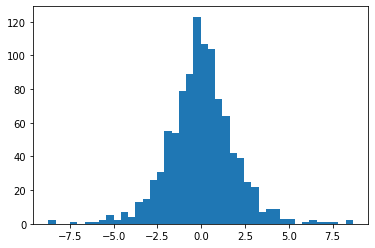

In [95]:
i = 0
plt.hist(res[i].resid, bins='auto');

In [112]:
# Nonparametric VaR
y_qtl = np.empty(5)
for i in range(5):
    y_qtl[i] = np.quantile(res[i].resid, 0.01)
y_qtl

array([ -5.04668418,  -3.89126371,  -5.77403675, -10.14329134,
        -5.27148661])

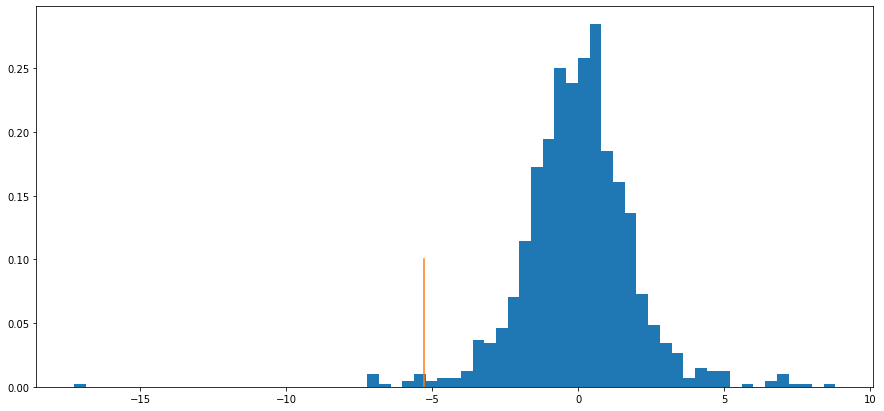

In [113]:
i = 4
plt.figure(figsize=(15, 7))
plt.hist(res[i].resid, bins='auto', density=True)
plt.plot([y_qtl[i], y_qtl[i]], [0, 0.1]);

In [114]:
tbl_var_npar = tbl_yhat.copy()
tbl_var_npar.iloc[:, 3:] = tbl_yhat.iloc[:, 3:] + np.tile(y_qtl, (8, 1))
tbl_var_npar

,Mkt-RF,SMB,HML,Cnsmr,Manuf,HiTec,Hlth,Other
0,-5.0,0.0,0.0,-9.528684,-8.760364,-10.576037,-14.283791,-10.769187
1,-5.0,0.0,-2.0,-9.517084,-9.078564,-9.924037,-13.906091,-11.510287
2,-5.0,-2.0,0.0,-9.553384,-8.568164,-10.649537,-14.092991,-10.901887
3,-5.0,-2.0,-2.0,-9.541784,-8.886364,-9.997437,-13.715291,-11.642987
4,-10.0,0.0,0.0,-14.134984,-13.667764,-15.510237,-18.742291,-16.043887
5,-10.0,0.0,-2.0,-14.123384,-13.985964,-14.858137,-18.364591,-16.784987
6,-10.0,-2.0,0.0,-14.159684,-13.475564,-15.583637,-18.551591,-16.176487
7,-10.0,-2.0,-2.0,-14.148084,-13.793764,-14.931537,-18.173891,-16.917687


In [111]:
tbl_yhat.iloc[:, 3:] + y_qtl[None, :]

,Cnsmr,Manuf,HiTec,Hlth,Other
0,-9.528684,-8.760364,-10.576037,-14.283791,-10.769187
1,-9.517084,-9.078564,-9.924037,-13.906091,-11.510287
2,-9.553384,-8.568164,-10.649537,-14.092991,-10.901887
3,-9.541784,-8.886364,-9.997437,-13.715291,-11.642987
4,-14.134984,-13.667764,-15.510237,-18.742291,-16.043887
5,-14.123384,-13.985964,-14.858137,-18.364591,-16.784987
6,-14.159684,-13.475564,-15.583637,-18.551591,-16.176487
7,-14.148084,-13.793764,-14.931537,-18.173891,-16.917687


In [110]:
y_qtl

array([ -5.04668418,  -3.89126371,  -5.77403675, -10.14329134,
        -5.27148661])

In [127]:
# Nonparametric ES
y_es = np.empty(5)
e = np.empty((len(exr), 5))
for i in range (5):
    e[:, i] = res[i].resid
    y_es[i] = e[:, i][e[:, i] < y_qtl[i]].mean()
y_es

array([ -6.24472925,  -4.6056296 ,  -6.76072572, -12.24951784,
        -7.26086301])

In [128]:
tbl_es_npar = tbl_yhat.copy()
tbl_es_npar.iloc[:, 3:] = tbl_yhat.iloc[:, 3:] + np.tile(y_es, (8, 1))
tbl_es_npar

,Mkt-RF,SMB,HML,Cnsmr,Manuf,HiTec,Hlth,Other
0,-5.0,0.0,0.0,-10.726729,-9.47473,-11.562726,-16.390018,-12.758563
1,-5.0,0.0,-2.0,-10.715129,-9.79293,-10.910726,-16.012318,-13.499663
2,-5.0,-2.0,0.0,-10.751429,-9.28253,-11.636226,-16.199218,-12.891263
3,-5.0,-2.0,-2.0,-10.739829,-9.60073,-10.984126,-15.821518,-13.632363
4,-10.0,0.0,0.0,-15.333029,-14.38213,-16.496926,-20.848518,-18.033263
5,-10.0,0.0,-2.0,-15.321429,-14.70033,-15.844826,-20.470818,-18.774363
6,-10.0,-2.0,0.0,-15.357729,-14.18993,-16.570326,-20.657818,-18.165863
7,-10.0,-2.0,-2.0,-15.346129,-14.50813,-15.918226,-20.280118,-18.907063


In [129]:
tbl_es_npar = tbl_yhat.copy()
tbl_es_npar.iloc[:, 3:] = tbl_yhat.iloc[:, 3:] + y_es[None, :]
tbl_es_npar

,Mkt-RF,SMB,HML,Cnsmr,Manuf,HiTec,Hlth,Other
0,-5.0,0.0,0.0,-10.726729,-9.47473,-11.562726,-16.390018,-12.758563
1,-5.0,0.0,-2.0,-10.715129,-9.79293,-10.910726,-16.012318,-13.499663
2,-5.0,-2.0,0.0,-10.751429,-9.28253,-11.636226,-16.199218,-12.891263
3,-5.0,-2.0,-2.0,-10.739829,-9.60073,-10.984126,-15.821518,-13.632363
4,-10.0,0.0,0.0,-15.333029,-14.38213,-16.496926,-20.848518,-18.033263
5,-10.0,0.0,-2.0,-15.321429,-14.70033,-15.844826,-20.470818,-18.774363
6,-10.0,-2.0,0.0,-15.357729,-14.18993,-16.570326,-20.657818,-18.165863
7,-10.0,-2.0,-2.0,-15.346129,-14.50813,-15.918226,-20.280118,-18.907063


In [130]:
tbl_es_par

,Mkt-RF,SMB,HML,Cnsmr,Manuf,HiTec,Hlth,Other
0,-5.0,0.0,0.0,-9.572826,-8.639046,-10.434664,-13.041249,-10.651158
1,-5.0,0.0,-2.0,-9.561226,-8.957246,-9.782664,-12.663549,-11.392258
2,-5.0,-2.0,0.0,-9.597526,-8.446846,-10.508164,-12.850449,-10.783858
3,-5.0,-2.0,-2.0,-9.585926,-8.765046,-9.856064,-12.472749,-11.524958
4,-10.0,0.0,0.0,-14.179126,-13.546446,-15.368864,-17.499749,-15.925858
5,-10.0,0.0,-2.0,-14.167526,-13.864646,-14.716764,-17.122049,-16.666958
6,-10.0,-2.0,0.0,-14.203826,-13.354246,-15.442264,-17.309049,-16.058458
7,-10.0,-2.0,-2.0,-14.192226,-13.672446,-14.790164,-16.931349,-16.799658


# Answer guide #
The changes in factors HML and SMB have little effect on any of these tail risk quantities. The variation in Market premium from -5 to -10% has a very large effect on all the quantities, making each more extreme, whether assuming a Gaussian distribution, or using sample percentiles. Also, the tail risk quantities when using a Gaussian distribution tend to be less extreme than when using sample percentiles.  The VaR estimates are more than 0.5% more extreme, while the ES estimates are more than 1% more extreme, when using the sample percentile method compared to the Gaussian distribution. This is because the estimated residuals have fat tails and are not close to a Gaussian distribution.

The VaR and ES results clearly show that the Health sector has the highest risk profile regarding tail risk. This is the opposite result when only looking at expected returns, where Health had the lowest risk profile. This result is partially due to Health having the highest variance among the sectors, influencing VaR and ES quantities to further below the expected value for that sector. Manufacturing seems to have the lowest tail risk profile, though pretty similar to Consumer and HiTec sectors. The Other sector has slightly lower tail risk than the Health sector.

Here we see the value of tail risk forecasting and what it adds to risk profiles and risk information. Though Health had the least extreme expected returns, the larger variation in Health returns means that on a 1 in 100 bad day for any of these sectors, Health would suffer the worst losses and most extreme negative returns. 

Consistent differences between the VaR and ES quantities, under Gaussian or sample-based methods, can be explained by the lack of Gaussianity of each of the sector returns, as now illustrated. 

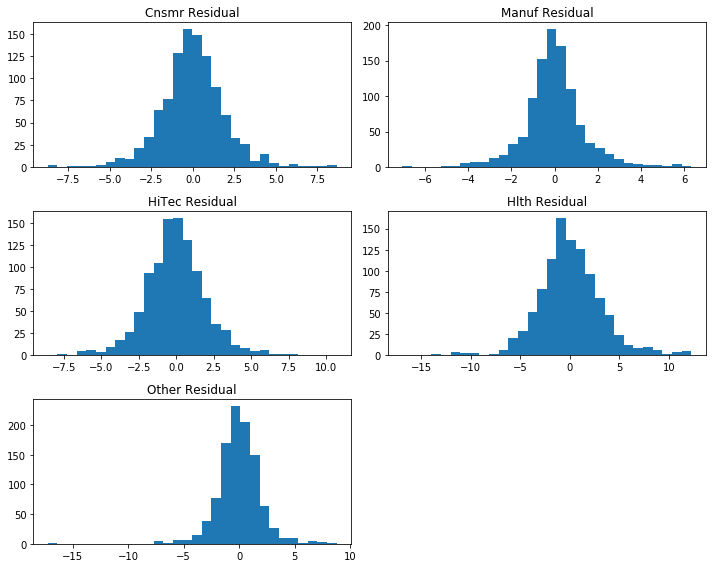

In [31]:
j = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [2, 0]])
fig, ax = plt.subplots(3, 2, figsize=(10, 8))
for i in range(5):
    ax[j[i, 0], j[i, 1]].hist(e[:,i], bins=30)
    ax[j[i, 0], j[i, 1]].set_title('{} Residual'.format(exr.columns[i]))
ax[2,1].axis('off')
plt.tight_layout()
plt.show()

In [32]:
jb, p_jb, sk, kt = jarque_bera(e)

In [33]:
tbl_jb = pd.DataFrame({'JB p-value': p_jb.round(4), 'Skewness': sk.round(4), 'Kurtosis': kt.round(4)}, 
                      index=exr.columns[:5])
tbl_jb

,JB p-value,Skewness,Kurtosis
Cnsmr,0.0,0.0754,5.3068
Manuf,0.0,0.3089,6.2502
HiTec,0.0,0.2121,5.4096
Hlth,0.0,-0.0564,5.6389
Other,0.0,-0.4944,11.0257


# Answer guide #
Clearly, all sectors are more fat-tailed than a Gaussian and are more peaked in the centre too. All J-B tests confirm that Gaussianity can be strongly rejected in each sector return series.

#### (d) Using your answers in (b) and (c),discuss the risk properties of each industry portfolio and also how you could protect your investment in each against the situations in part (b).

# Answer guide # 
See discussion above. The idea behind VaR and ES is to give an estimate of how much capital needs to be set aside to protect against low probability market and/or portfolio return events. The tables above estimate how much each sector might lose on low probability adverse event days on the market and can help guide capital allocation decisions. That is one of the goals of the Basle Capital Accord. It seems that to avoid default on the worst days on the market considered above (i.e. -10%), investors should have 15-20% of their investment set aside to protect their likely loss. 

#### (e) How likely are the scenarios in part (b)?

In [34]:
var5 = tbl_var_par.iloc[0, 3:]
var10 = tbl_var_par.iloc[4, 3:]
n = len(exr)

n_mkt5 = np.sum(exr['Mkt-RF'] < -5)
n_mkt10 = np.sum(exr['Mkt-RF'] < -10)

p_mkt5 = n_mkt5 / n
p_mkt10 = n_mkt10 / n
n_var5 = np.sum(exr.iloc[:, :5] < var5)
n_var10 = np.sum(exr.iloc[:, :5] < var10)
p_var_cond5 = n_var5 / n_mkt5
p_var_cond10 = n_var10 / n_mkt10
p_var_join5 = p_mkt5 * p_var_cond5
p_var_join10 = p_mkt10 * p_var_cond10
avr5 = exr.iloc[:, :5][exr.iloc[:, :5] < var5].mean()
avr10 = exr.iloc[:, :5][exr.iloc[:, :5] < var10].mean()
print(n_mkt5,p_mkt5,n_mkt10,p_mkt10)

117 0.11403508771929824 31 0.030214424951267055


In [35]:
tbl_p_mkt5 = pd.DataFrame({
    'No.<1%VaR': n_var5,
    'Prob<VaR|Mkt': p_var_cond5,
    'Prob<VaR&Mkt': p_var_join5,
    'Avg. Return': avr5})
tbl_p_mkt5

,No.<1%VaR,Prob<VaR|Mkt,Prob<VaR&Mkt,Avg. Return
Cnsmr,36,0.307692,0.035088,-13.672500
Manuf,47,0.401709,0.045809,-13.052766
HiTec,42,0.358974,0.040936,-14.112381
Hlth,18,0.153846,0.017544,-17.855000
Other,42,0.358974,0.040936,-15.790476


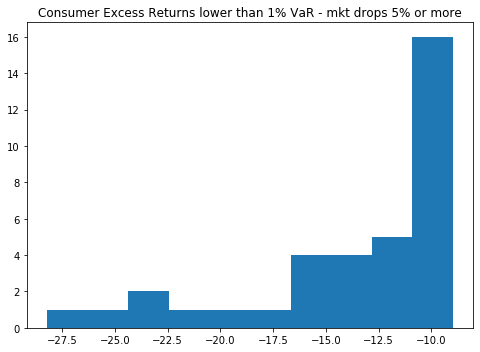

In [42]:
plt.figure(figsize=(7, 5))
plt.hist(exr['Cnsmr'][exr['Cnsmr'] < var5['Cnsmr']])
plt.title('Consumer Excess Returns lower than 1% VaR - mkt drops 5% or more')
plt.tight_layout()
plt.show()

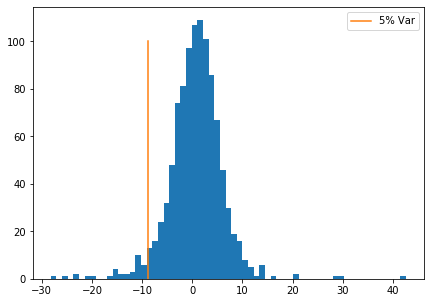

In [40]:
plt.figure(figsize=(7, 5))
plt.hist(exr['Cnsmr'], bins='auto');
plt.plot([var5['Cnsmr'], var5['Cnsmr']], [0, 100], label='5% Var');
plt.legend();

#  Answer guide #

The market dropped by 5% or more in 117 months in this sample of 1026 months, i.e. in 11% of the months in this period. The market dropped by 10% or more in 31 months, or 3% of the months in this period. Thus, these are not very unlikely events at all: being about once a year (dropping by > 5%) and about once every 4 years (dropping by > 10%)! Clearly, analysts should factor in such drops into their risk calculations; our stress testing choice seems justified in this case.


The table above illustrates what happens in each sector when the market dropped by 5% or more in our dataset. For example, each sector had 15% (Health) - 40% (Manufacturing) of returns below their 1% VaR estimate (the Gaussian one) in months when the market dropped by 5% or more. The observed probability of being less than the 1% VaR and market being < -5% are 0.018 (Health) to 0.046 (Manufacturing)


In the 117 months that the market dropped by 5% or more, the Consumer portfolio also dropped by more than its 1% VaR estimate (using Gaussian distribution) in 36 of those months, or 31% of those months. Thus the combined chance, from this sample, of the market dropping by 5% or more and consumer returns being lower than their 1% VaR is 0.125*0.266 = 0.035 or 3.5% (i.e. 36/1026)! Note that 36/117 * 117/1026 = 34/1026 = 3.5%. Thus, the event of the market dropping by 5% or more AND Consumer return being lower than its 1% VaR did happen in 3.3% (i.e. 36) of the months in this sample period. The average Consumer return for these 34 months was -13.7%. A histogram of these 34 Consumer returns is given below.

The value -13.7% is another estimate of ES (0.01), for Consumer, for when market return is less than -5%.  Again, the ES(0.01) estimate for Health in the table above is the most extreme, followed by Other; the three other sectors are similar in their ES estimates. 

In [77]:
tbl_p_mkt10 = pd.DataFrame({
    'No.<1%VaR': n_var10,
    'Prob<VaR|Mkt': p_var_cond10,
    'Prob<VaR&Mkt': p_var_join10,
    'Avg. Return': avr10})
tbl_p_mkt10

,No.<1%VaR,Prob<VaR|Mkt,Prob<VaR&Mkt,Avg. Return
Cnsmr,13,0.419355,0.012671,-19.048462
Manuf,17,0.548387,0.016569,-18.057647
HiTec,14,0.451613,0.013645,-19.135000
Hlth,9,0.290323,0.008772,-22.315556
Other,18,0.580645,0.017544,-20.481111


# Answer guide #
In the 31 months that the market dropped by 10% or more in our sample, the Consumer portfolio also dropped by more than its 1% VaR estimate in 13 of those months, or 42% of those months! Thus the combined chance, from this sample, of the market dropping by 10% or more and consumer returns being lower than their 1% VaR is (13/1026=) 0.03*0.382 = 0.0128 or 1.3%! The average Consumer return for these 13 months was -19%. The value -19% is another estimate of ES (0.01), for Consumer, for when market return is less than -10%. Again, the ES(0.01) estimate for Health in the table above is the most extreme, followed by Other; the three other sectors are again similar in their ES estimates. The histogram below shows the 13 Consumer returns below the VaR (0.01) estimate when the market dropped by more than 10%.

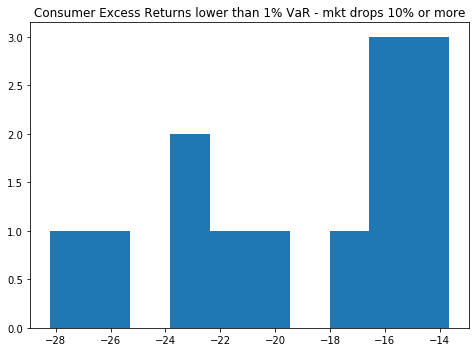

In [78]:
plt.figure(figsize=(7, 5))
plt.hist(exr['Cnsmr'][exr['Cnsmr'] < var10['Cnsmr']])
plt.title('Consumer Excess Returns lower than 1% VaR - mkt drops 10% or more')
plt.tight_layout()
plt.show()

### Question 2 PCA and Factor modelling

#### Data
We use the data from the textbook by Tsay, in Chapter 9, being monthly returns on IBM, HPQ, Intel, JP Morgan and Bank of America, from January, 1990 to December, 2008.

In [131]:
data = pd.read_csv('Tsay_FM_data.txt', sep=" ")
data

,IBM,HPQ,INTC,JPM,BAC
0,4.670132,-5.715888,13.534180,-14.858700,-9.639196
1,6.344511,-3.419090,1.880900,-0.486582,6.565384
2,2.142973,6.138104,3.658937,-6.322525,-13.835790
3,2.673053,-4.756132,-5.539855,0.000000,-1.954476
4,10.617640,9.034880,20.009520,15.796310,2.853595
...,...,...,...,...,...
223,-4.596960,4.623548,3.628757,-5.410778,-5.498008
224,-3.997340,-1.287047,-19.969930,19.334560,13.497570
225,-22.955530,-18.891730,-15.560170,-11.492280,-37.023650
226,-12.433830,-8.161144,-13.976220,-26.459730,-39.701940


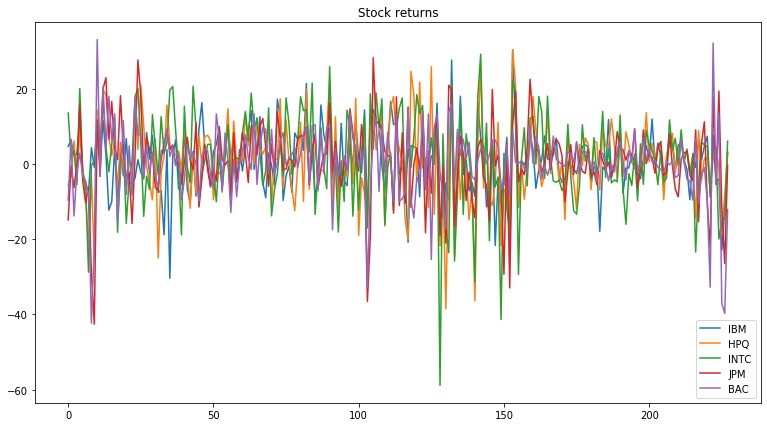

In [132]:
data.plot(figsize=(13, 7))
plt.title('Stock returns')
plt.legend()
plt.show()

#### (a) Form the correlation matrix from these asset return series and comment on the apparent relationships observed. Does it make sense to do a PCA on these variables?

In [133]:
corr_mat = data.corr().round(4)
corr_mat

,IBM,HPQ,INTC,JPM,BAC
IBM,1.0000,0.4620,0.4593,0.3384,0.2545
HPQ,0.4620,1.0000,0.5495,0.3889,0.2591
INTC,0.4593,0.5495,1.0000,0.3578,0.2521
JPM,0.3384,0.3889,0.3578,1.0000,0.6836
BAC,0.2545,0.2591,0.2521,0.6836,1.0000


# Answer guide #
To run a PCA, we require correlated variables, but none of which are perfectly correlated. All the pairwise correlations are positive, not close to 0 and not close to 1 either. Seems like a good candidate for a PCA. The plots below also illustrate that the relationships seem not too far from linear, again supporting PCA as a good choice to reduce the dimension of the data. 

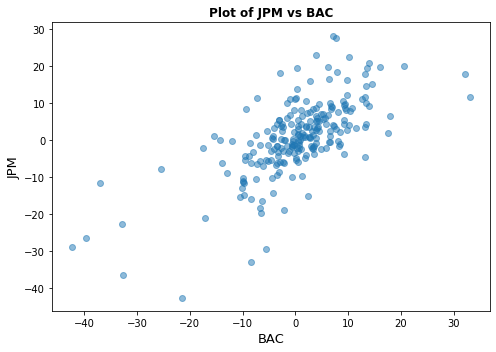

In [134]:
plt.figure(figsize=(7, 5))
plt.scatter(data['BAC'], data['JPM'], alpha=0.5)
plt.xlabel('BAC', fontsize=13)
plt.ylabel('JPM', fontsize=13)
plt.title('Plot of JPM vs BAC', weight='bold')
plt.tight_layout()
plt.show()

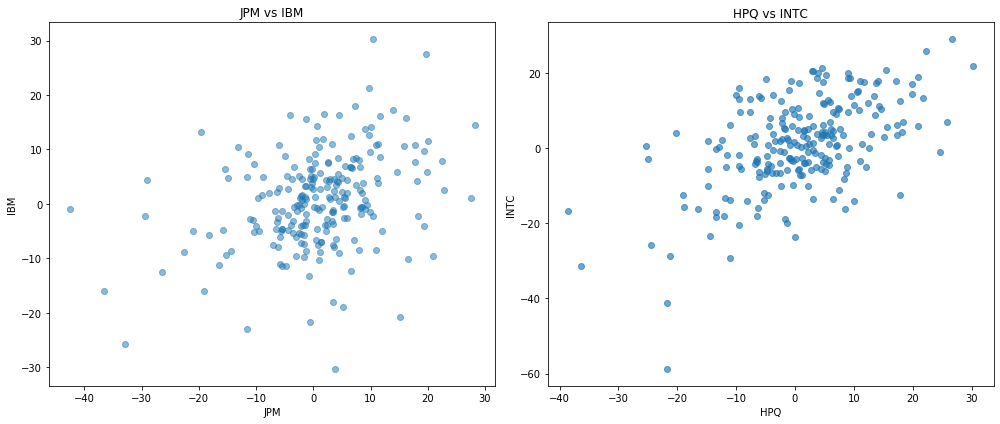

In [83]:
fig, ax= plt.subplots(1,2, figsize=(14,6))
ax[0].scatter(data['JPM'], data['IBM'], alpha=0.5)
ax[0].set(title='JPM vs IBM', ylabel='IBM', xlabel='JPM')
ax[1].scatter(data['HPQ'], data['INTC'], alpha=0.65)
ax[1].set(title='HPQ vs INTC', ylabel='INTC', xlabel='HPQ')
plt.tight_layout()
plt.show()

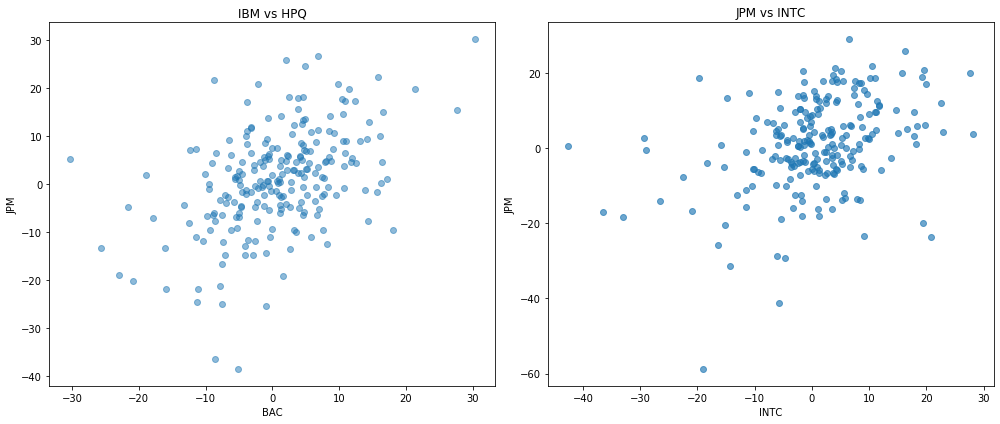

In [11]:
fig, ax= plt.subplots(1,2, figsize=(14,6))
ax[0].scatter(data['IBM'], data['HPQ'], alpha=0.5)
ax[0].set(title='IBM vs HPQ', ylabel='JPM', xlabel='BAC')
ax[1].scatter(data['JPM'], data['INTC'], alpha=0.65)
ax[1].set(title='JPM vs INTC', ylabel='JPM', xlabel='INTC')
plt.tight_layout()
plt.show()

#### (b) Perform a PCA on this data and report the results.

In [136]:
# Our PCA implementation
class MyPca:
    def __init__(self, data):
        self.data = data.values
        self.n = self.data.shape[0]
        self.d = self.data.shape[1]
        self.mu = np.mean(self.data, axis=0)
        self.eigval = None
        self.weight = None

    def fit(self):
        c = np.cov(self.data.T)
        eigval, weight = np.linalg.eig(c)
        idx = np.argsort(-eigval)
        self.eigval = eigval[idx]
        self.weight = weight[:, idx]
    
    def transform(self, n_comp):
        x = self.data - np.tile(self.mu, (self.n, 1))
        return np.dot(x, self.weight[:, :n_comp])
    
    def prop_var_explained(self):
        return self.eigval / np.sum(self.eigval)
    
    def biplot2d(self):
        ax = plt.axes()
        for i in range(self.d):
            w = self.weight[i, :]
            ax.plot([0, w[0]], [0, w[1]])
            ax.scatter(w[0], w[1])
        ax.axhline(y=0, color='k', alpha=0.6)
        ax.axvline(x=0, color='k', alpha=0.6)
        lim = np.max(np.abs(self.weight[:, :2]))
        lim = lim + 0.1 * lim
        ax.axis([-lim, lim, -lim, lim])
        ax.grid(True)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        return ax
    
    def biplot3d(self):
        ax = plt.axes(projection="3d")
        for i in range(self.d):
            w = self.weight[i, :]
            ax.plot([0, w[0]], [0, w[1]], [0, w[2]])
            ax.scatter(w[0], w[1], w[2])
        lim = np.max(np.abs(self.weight[:, :3]))
        lim = lim + 0.1 * lim
        ax.axis([-lim, lim, -lim, lim])
        ax.set_zbound(lower=-lim, upper=lim)
        ax.plot([-lim, lim], [0, 0], [0, 0], 'k', alpha=0.6)
        ax.plot([0, 0], [-lim, lim], [0, 0], 'k', alpha=0.6)
        ax.plot([0, 0], [0, 0], [-lim, lim], 'k', alpha=0.6)
        ax.grid(True)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        return ax

In [137]:
data.head()

,IBM,HPQ,INTC,JPM,BAC
0,4.670132,-5.715888,13.534180,-14.858700,-9.639196
1,6.344511,-3.419090,1.880900,-0.486582,6.565384
2,2.142973,6.138104,3.658937,-6.322525,-13.835790
3,2.673053,-4.756132,-5.539855,0.000000,-1.954476
4,10.617640,9.034880,20.009520,15.796310,2.853595


In [138]:
# Weights
pca = MyPca(data)
pca.fit()
print(pca.weight)

[[-0.32975133 -0.13927753 -0.26430833  0.89543224  0.01442399]
 [-0.48261645 -0.27857184 -0.70092309 -0.42981955  0.11593566]
 [-0.58078796 -0.47811891  0.65159201 -0.09617768  0.01628962]
 [-0.44760887  0.55016458  0.01279894 -0.06417771 -0.70191356]
 [-0.34738604  0.60968905  0.11879383 -0.0093459   0.70242642]]


In [139]:
c_name = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5']
tbl_pca = pd.DataFrame(pca.weight.round(4), index=data.columns, columns=c_name)
tbl_pca

,PC 1,PC 2,PC 3,PC 4,PC 5
IBM,-0.3298,-0.1393,-0.2643,0.8954,0.0144
HPQ,-0.4826,-0.2786,-0.7009,-0.4298,0.1159
INTC,-0.5808,-0.4781,0.6516,-0.0962,0.0163
JPM,-0.4476,0.5502,0.0128,-0.0642,-0.7019
BAC,-0.3474,0.6097,0.1188,-0.0093,0.7024


In [140]:
tbl_mat = np.vstack([
        pca.eigval,
        pca.prop_var_explained(),
        np.cumsum(pca.prop_var_explained())])
tbl_eigval = pd.DataFrame(tbl_mat.round(4),
    index=['Eigenvalue', '% Variance', 'Cumulative'],
    columns=c_name)
tbl_eigval

,PC 1,PC 2,PC 3,PC 4,PC 5
Eigenvalue,284.1675,112.9316,57.4371,46.8064,29.8740
% Variance,0.5349,0.2126,0.1081,0.0881,0.0562
Cumulative,0.5349,0.7475,0.8557,0.9438,1.0000


In [141]:
# Eigenvalues (explained variance)
print(pca.eigval)

[284.16754855 112.93161642  57.43709481  46.80635542  29.87402937]


In [142]:
# Explained variance (%)
print(pca.prop_var_explained())

[0.53493721 0.21259051 0.10812367 0.08811161 0.056237  ]


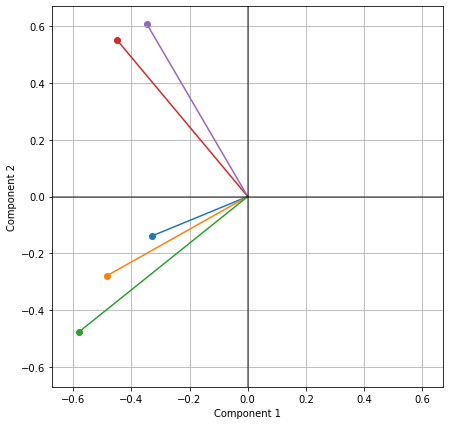

In [18]:
# Biplot
plt.figure(figsize=(7, 7))
pca.biplot2d()
plt.show()

In [19]:
tbl_pca

,PC 1,PC 2,PC 3,PC 4,PC 5
IBM,-0.3298,-0.1393,-0.2643,0.8954,0.0144
HPQ,-0.4826,-0.2786,-0.7009,-0.4298,0.1159
INTC,-0.5808,-0.4781,0.6516,-0.0962,0.0163
JPM,-0.4476,0.5502,0.0128,-0.0642,-0.7019
BAC,-0.3474,0.6097,0.1188,-0.0093,0.7024


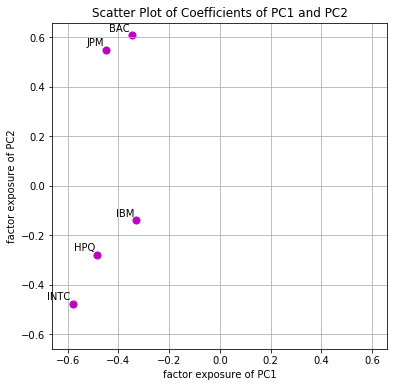

In [44]:
plt.figure(figsize=(6, 6))
plt.scatter(tbl_pca.iloc[:, 0], tbl_pca.iloc[:, 1], s=50, c='m')
plt.grid()

for asset, pc1, pc2 in zip(tbl_pca.index, tbl_pca.loc[:, 'PC 1'], tbl_pca.loc[:, 'PC 2']):
    plt.annotate(asset, xy=(pc1, pc2), xytext=(-2, 2), 
                 textcoords='offset points', ha='right', va='bottom')
    
plt.title('Scatter Plot of Coefficients of PC1 and PC2')
plt.xlabel('factor exposure of PC1')
plt.ylabel('factor exposure of PC2');

plt.xlim(-0.66, 0.66)
plt.ylim(-0.66, 0.66);

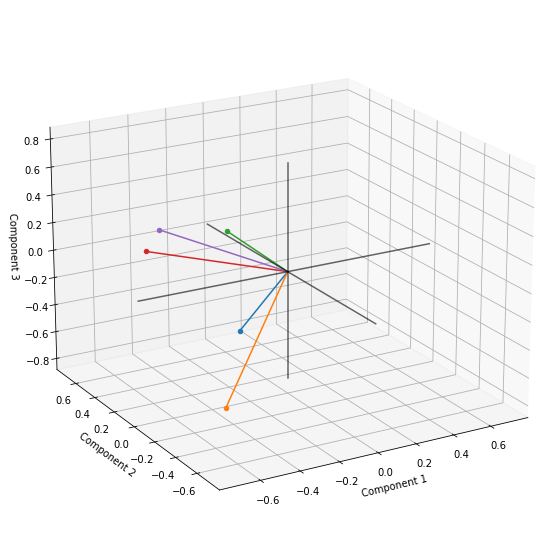

In [38]:
# 3D biplot
plt.figure(figsize=(10, 10))
ax = pca.biplot3d()
ax.view_init(20, -120)
plt.show()

#### (c) How many principal components do you think are adequate to explain these variables? Describe the PCs found, do they make intuitive sense and/or have a relevant or useful interpretation?

In [143]:
# Variation expalined by each individual component
pca.prop_var_explained()

array([0.53493721, 0.21259051, 0.10812367, 0.08811161, 0.056237  ])

In [144]:
# Cumulated Variation as we included more components
np.cumsum(pca.prop_var_explained())

array([0.53493721, 0.74752772, 0.85565139, 0.943763  , 1.        ])

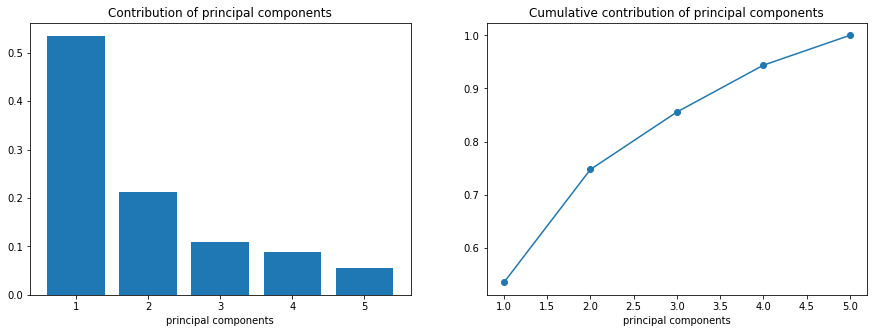

In [85]:
plt.figure(figsize=(15, 5))

number_of_components = len(pca.prop_var_explained())

plt.subplot(1, 2, 1)
plt.bar(np.arange(number_of_components) + 1, pca.prop_var_explained())
plt.title('Contribution of principal components')
plt.xlabel('principal components')

plt.subplot(1, 2, 2)
plt.plot(np.arange(number_of_components) + 1, np.cumsum(pca.prop_var_explained()), 'o-')
plt.title('Cumulative contribution of principal components')
plt.xlabel('principal components');

# Answer guide #
The first three PCs together capture 86% of total variance; the 1st 4 components capture 94%. All 5 eigenvalues are greater than 1 (this is not the usual case and doesn't help us choose m). We can't use all 5 PCs. I would say most anaylsts would choose either $m=3$ or 4 PCs here. My choice is $m =3$ PCs.

The first PC has close to equal weights on each of the 5 series. It seems logical that this PC represents an underlying market factor. However, the weights are all negative! Thus, this PC is actually negatively related to all these 5 series.

However, the collective signs of the PC weights are irrelevant to the analysis, since  $a_1′a_1 =1 =(−a_1)′(−a_1)$ , and e.g.  $a_1′a_2=0=(−a_1)′a_2=−a_1'a_2$  and Var$(a_1′y)=a_1'\lambda_1 a_1= (-a_1)'\lambda_1 (-a_1) = \lambda_1 = $ Var $(−a_1′y)$ .

Thus, any of the PC weight vectors can be multiplied by -1 without changing anything in the analysis or conclusions. 

So, I use the negative of the 1st PC i.e.  $−a_1′y$  in the subsequent analysis below. I do this because it makes more sense in the context of having an underlying market factor being (close to) an equally weighted sum of the 5 series.

The 2nd PC contrasts the series JPM (JP Morgan), BAC (Bank of America) with series the INTC (Intel), HPQ (Hewlett-Packard) and IBM. This is a PC that contrasts financial-related assets with tech-related assets. The 2D biplot illustrates this contrast and asset grouping well.

The 3rd component contrasts tech-related assets, specifically INTC and HPQ.

The 1st component captures 53.5% of the total variance and has a variance of 284.17. The 2nd component captures a further 21.3% of total variance; the 3rd captures 10.8% etc.

In [46]:
pc = pca.transform(n_comp=3)
pc[:,0] = (-1)*pc[:,0]
# print(pc[:,0])

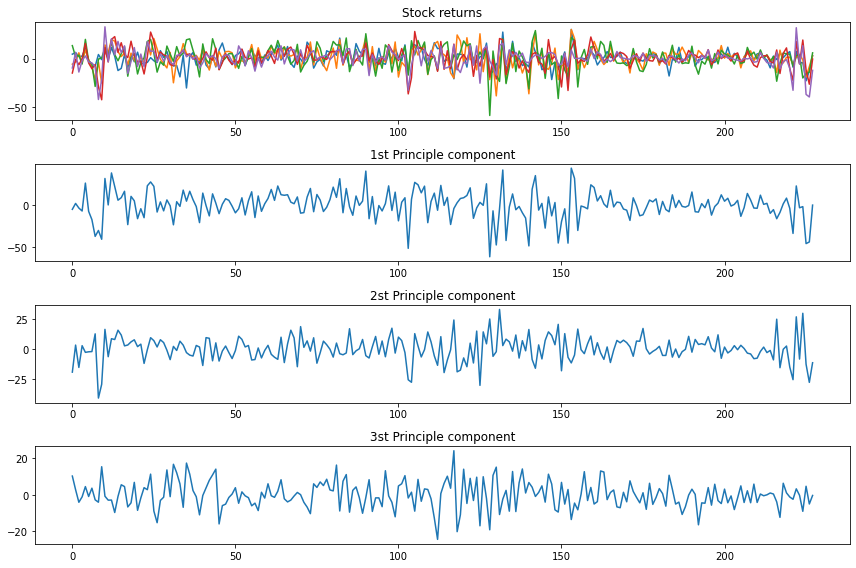

In [73]:
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
ax[0].plot(data)
ax[0].set_title('Stock returns')
ax[1].plot(pc[:,0])
ax[1].set_title('1st Principle component')
ax[2].plot(pc[:,1])
ax[2].set_title('2st Principle component')
ax[3].plot(pc[:,2])
ax[3].set_title('3st Principle component')
plt.tight_layout()
plt.show()

# Answer guide #
The 1st PC seems to follow the general overall collective major trends/aspects/traits of the 5 series. It acts sort of like the average behavior of the 5 series. See the plot below to confirm. 

Despite being uncorrelated with PC 1, PC 2 also seems to capture some general trends in the 5 series. However, it misses the big dips in return by INTC (green) in abojut the middle of the time period (from time point 125 to 160). Both PC 1 and PC 2 also capture/mimic the higher and lower volatility periods in the 5 series (except for the INTC negative outliers)

The 3rd PC seems to capture some behavior that is not obvious in the 5 series (to me at least). In particular, it is not showing higher volatility when the 5 series (or PC 1 and 2) do. 

The plots below further illustrate these assessments, illustrating that PC 1 captures the volatility and trends of the 5 series the best. 

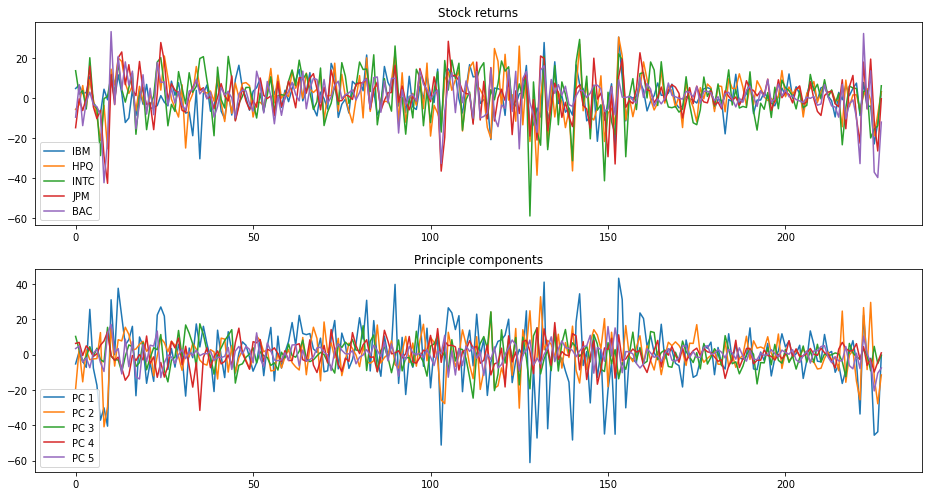

In [74]:
pc = pca.transform(n_comp=5)
pc[:,0] = (-1)*pc[:,0]
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
data.plot(figsize=(13, 7), ax=ax[0])
ax[0].set_title('Stock returns')
ax[1].plot(pc)
ax[1].legend(['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5'])
ax[1].set_title('Principle components')
plt.tight_layout()
plt.show()

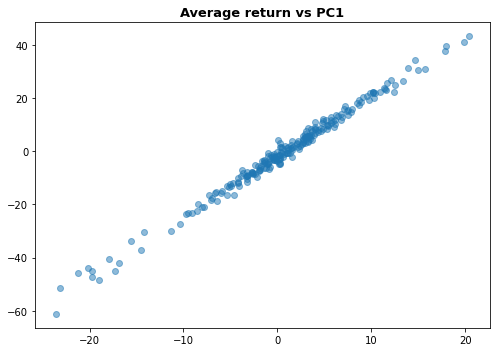

In [75]:
plt.figure(figsize=(7, 5))
plt.scatter(data.mean(axis=1), pc[:,0], alpha=0.5)
plt.title('Average return vs PC1', fontsize=13, weight='bold')
plt.tight_layout()
plt.show()

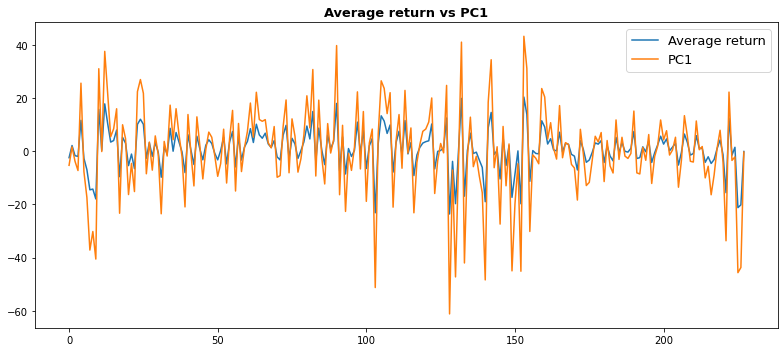

In [76]:
plt.figure(figsize=(11, 5))
plt.plot(data.mean(axis=1), label='Average return')
plt.plot(pc[:,0], label='PC1')
plt.title('Average return vs PC1', fontsize=13, weight='bold')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

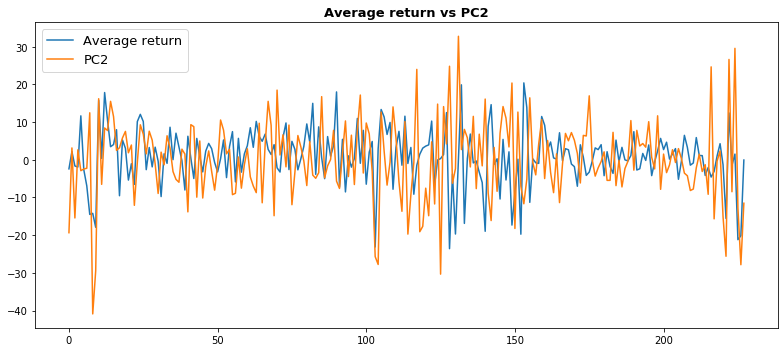

In [47]:
plt.figure(figsize=(11, 5))
plt.plot(data.mean(axis=1), label='Average return')
plt.plot(pc[:,1], label='PC2')
plt.title('Average return vs PC2', fontsize=13, weight='bold')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

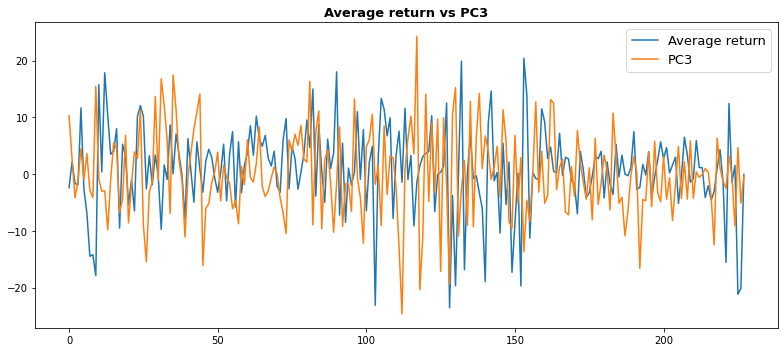

In [79]:
plt.figure(figsize=(11, 5))
plt.plot(data.mean(axis=1), label='Average return')
plt.plot(pc[:,2], label='PC3')
plt.title('Average return vs PC3', fontsize=13, weight='bold')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

# Answer guide #
It seems PC2 and PC3 do not follow the mean return, or PC1, closely at all. 